In [1]:
# PROCESS THE GAIA CATALOG OF VARIABLE STARS:
# Gaia has a table for RR Lyrae stars and Cepheid variables
# gaiadr3.vari_rrlyrae & gaiadr3.vari_cepheid
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  MAR 2024 CREATE JUPYTER NOTEBOOK

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table, join, vstack
from astropy.io import ascii

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [3]:
# Define the metadata for the data set.  NEED TO EDIT
#https://www.aanda.org/articles/aa/full_html/2023/06/aa43964-22/aa43964-22.html
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Cepheid and RRLyrae Variable Stars'

metadata['catalog'] = 'The Gaia Catalogue of Nearby Stars (Gaia Collaboration, 2021)'  #need to edit
metadata['catalog_author'] = 'Gaia Collaboration'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'doi:10.1051/0004-6361/202039498'
metadata['catalog_bibcode'] = '2021A&A...649A...6G'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Variable stars'
metadata['data_group_desc'] = 'Variable stars in the Milky Way mapped by Gaia'
metadata['data_group_desc_long'] = 'RR Lyrae stars are excellent tracers of the oldest stars (ages ≳ 9–10 Gyr) and standard candles for measuring the distance to stellar systems that are mainly composed of an old stellar population. The Gaia Third Data Release (DR3) publishes a catalogue of full-sky RR Lyrae stars observed during the initial 34 months of science operations. They were processed through the Specific Object Study (SOS) pipeline, which was developed to validate and characterise Cepheids and RR Lyrae stars (SOS Cep&RRL) observed by Gaia.'
metadata['fileroot'] = 'variable_stars'

file_functions.generate_license_file(metadata)

In [4]:
#query cepheid table

#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in less than a minute
#file is small, 15021 objects
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 **we can add more params later, maybe get metallicity, periods, etc

job = Gaia.launch_job_async("select a.source_id, "
                            "b.ra, b.dec, b.pmra, b.pmdec, b.parallax, b.parallax_error, b.phot_g_mean_mag, b.bp_g, b.radial_velocity, b.radial_velocity_error, b.grvs_mag, b.rv_template_teff, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
                            "from gaiadr3.vari_cepheid a inner join gaiadr3.gaia_source b on a.source_id = b.source_id "
                            "left join external.gaiaedr3_distance bj on a.source_id = bj.source_id",
                            dump_to_file=False)

#Put the resulting table into a Table
cepheids = job.get_results()
cepheids['variable_type'] = [1]*len(cepheids)

Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Removed jobs: '1716749489299O'. [astroquery.utils.tap.core]
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [5]:
#query RR Lyrae table

#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in a few minutes
#file is smallish, 271779 objects
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 **we can add more params later, maybe get metallicity, periods, etc

job = Gaia.launch_job_async("select a.source_id, "
                            "b.ra, b.dec, b.pmra, b.pmdec, b.parallax, b.parallax_error, b.phot_g_mean_mag, b.bp_g, b.radial_velocity, b.radial_velocity_error, b.grvs_mag, b.rv_template_teff, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
                            "from gaiadr3.vari_rrlyrae a inner join gaiadr3.gaia_source b on a.source_id = b.source_id "
                            "left join external.gaiaedr3_distance bj on a.source_id = bj.source_id",
                            dump_to_file=False)

#Put the resulting table into a Table
rrls = job.get_results()
rrls['variable_type'] = [2]*len(rrls)

Gaia.remove_jobs(job.jobid)

Gaia.logout()

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Removed jobs: '1716749507022O'. [astroquery.utils.tap.core]
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [6]:
rrls

<Table length=271779>
     SOURCE_ID              ra         ... r_lo_photogeo variable_type
                           deg         ...       pc                   
       int64             float64       ...    float32        int32    
------------------- ------------------ ... ------------- -------------
    177571127944832  46.05558586315165 ...      4772.949             2
    288243845193088  44.32290682471504 ...     5390.5283             2
    500243431117184  44.69810251269097 ...     5461.9805             2
    507222753405440  44.66531451824552 ...     6467.1685             2
    584630948352256  46.34146909549162 ...      5061.367             2
    782027645388032  46.69911546428052 ...     4691.1157             2
   1035533795140608  46.81721127988241 ...     5826.7544             2
   1407379179248512  42.88745471911522 ...     4516.0234             2
   1514169246023424  42.86075067925894 ...      4541.294             2
                ...                ... ...           ...           ...
6917231987704428416  315.5059898587102 ...     4647.1973             2
6917251096013784064  314.3706676335426 ...     3858.4094             2
6917264079699449600 314.44035972569105 ...      9570.725             2
6917277136400194688   314.433902393156 ...     3817.1306             2
6917321602197087360   313.960968491152 ...      6651.049             2
6917339056944238336  313.8386062617502 ...     3368.8213             2
6917382448997720064 314.43263039927626 ...     5027.6055             2
6917410658343125760 314.71782115612456 ...      8227.447             2
6917421554675423488  314.9801886178101 ...     5218.4365             2
6917504464723620992  315.2036380850936 ...      739.3281             2

In [7]:
data = vstack([cepheids, rrls])
data['variable_type'] = data.Column(data['variable_type'],
                            meta=collections.OrderedDict([('ucd', 'meta.vari_type')]),
                            description='Type of Variable Star: 1 indicates Cepheid, 2 indicates RR Lyrae')
data

<Table length=286800>
     SOURCE_ID              ra         ... r_lo_photogeo variable_type
                           deg         ...       pc                   
       int64             float64       ...    float32        int32    
------------------- ------------------ ... ------------- -------------
4658032774371311104  83.48962697026485 ...      9231.942             1
4658035626229427456  83.50979201197948 ...     5050.1035             1
4658036274856153856  83.19749527339663 ...      12960.82             1
4658036828819820800  83.19373243902551 ...     19517.873             1
4658039710832195200  83.02051676700864 ...     5326.3994             1
4658040745829467392  82.89706008824761 ...     13173.843             1
4658041222673354112  82.85302334713688 ...     6504.0913             1
4658041707905510912  82.58798954159604 ...        8515.1             1
4658042287684443648  82.61250645826465 ...     14355.084             1
                ...                ... ...           ...           ...
6917231987704428416  315.5059898587102 ...     4647.1973             2
6917251096013784064  314.3706676335426 ...     3858.4094             2
6917264079699449600 314.44035972569105 ...      9570.725             2
6917277136400194688   314.433902393156 ...     3817.1306             2
6917321602197087360   313.960968491152 ...      6651.049             2
6917339056944238336  313.8386062617502 ...     3368.8213             2
6917382448997720064 314.43263039927626 ...     5027.6055             2
6917410658343125760 314.71782115612456 ...      8227.447             2
6917421554675423488  314.9801886178101 ...     5218.4365             2
6917504464723620992  315.2036380850936 ...      739.3281             2

In [8]:
#setting dcalc based on r_med_geo (if>500pc and photogeo exists, we choose photogeo and set dcalc to 1, else geo and dcalc to 2)
data['dcalc'] = [1 if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else 2 for i in range(len(data))]

#setting metadata for dcalc
data['dcalc'] = data.Column(data['dcalc'],
                            meta=collections.OrderedDict([('ucd', 'meta.dcalc')]),
                            description='Distance Indicator: 1 indicates a Bailer-Jones photogeometric distance; 2 indicates a Bailer-Jones geometric distance')

#Choosing distance based on dcalc
data['bj_distance'] = [data['r_med_photogeo'][i] if data['dcalc'][i]==1 else data['r_med_geo'][i] for i in range(len(data))]
data['bj_distance'].unit=u.pc

#Choosing and calculating distance error based on the distance we chose
data['e_bj_dist'] = [((data['r_hi_photogeo'][i]-data['r_lo_photogeo'][i])/2)*u.pc if((not(np.ma.is_masked(data['r_med_photogeo'][i])))and(data['r_med_geo'][i]>500)) else ((data['r_hi_geo'][i]-data['r_lo_geo'][i])/2)*u.pc for i in range(len(data))]

In [9]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [10]:
#dropping stars with null distance
data.remove_rows([i for i in range(len(data)) if np.ma.is_masked(data['bj_distance'][i])])

In [11]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='radial_velocity', frame='icrs')

In [12]:
#calculating absolute magnitudes
#calculate absolute V mag based on apparent magnitude and distance
data['appmag'] = data.MaskedColumn(data=data['phot_g_mean_mag'],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.mag;em.opt.G')]),
                             format='{:.6f}',
                             description='Apparent magnitude in Gaia G-band')
data['absmag'] = data.MaskedColumn(data=[data['appmag'][i]+5-5*np.log10(data['dist_pc'][i]) for i in range(len(data))],
                             unit=u.mag,
                             meta=collections.OrderedDict([('ucd', 'phot.magAbs;em.opt.G')]),
                             format='{:.6f}',
                             description='Absolute magnitude in Gaia G-band')

In [13]:
#calculate luminosity based on absolute magnitude
data['lum'] = [10**(1.89 - 0.4*data['absmag'][i]) for i in range(len(data))]
small_luminosities = np.where((data['lum']>0.0) & (data['lum']<0.001))[0]
data['lum'][small_luminosities] = [0.001]*len(small_luminosities)

data['lum'] = data.MaskedColumn(data=data['lum'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.luminosity')]),
                             format='{:.6f}',
                             description='Stellar Luminosity')

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 6.0000e+00, 5.0000e+00, 2.0000e+00,
        2.0000e+00, 4.0000e+00, 4.0000e+00, 9.0000e+00, 9.0000e+00,
        8.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00, 9.0000e+00,
        1.2000e+01, 1.3000e+01, 9.0000e+00, 1.6000e+01, 8.0000e+00,
        1.7000e+01, 1.4000e+01, 6.0000e+00, 1.9000e+01, 2.4000e+01,
        2.5000e+01, 2.6000e+01, 2.9000e+01, 2.5000e+01, 3.0000e+01,
        3.1000e+01, 3.4000e+01, 2.5000e+01, 3.00

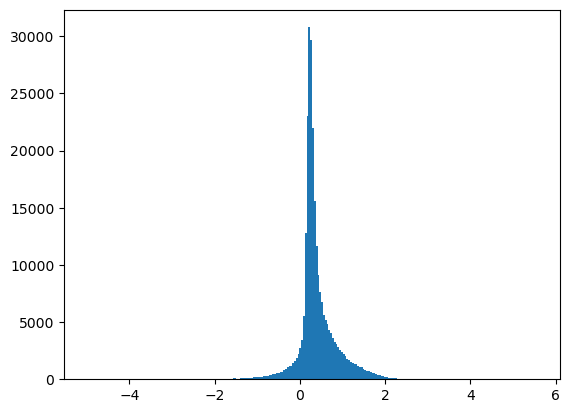

In [14]:
#setting color and visualizing
data['color'] = data.MaskedColumn(data=data['bp_g'],
                             unit=u.solLum,
                             meta=collections.OrderedDict([('ucd', 'phys.color')]),
                             format='{:.2f}',
                             description='Gaia BP-G color')
plt.hist(data['color'], bins=250)

<function matplotlib.pyplot.show(close=None, block=None)>

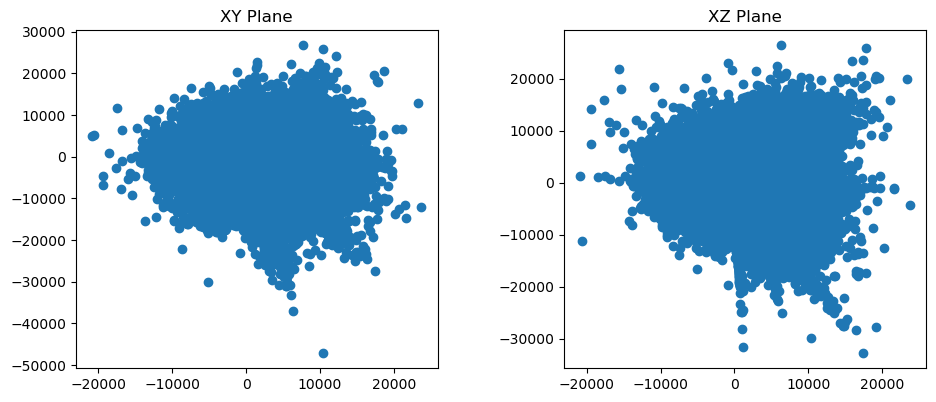

In [15]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

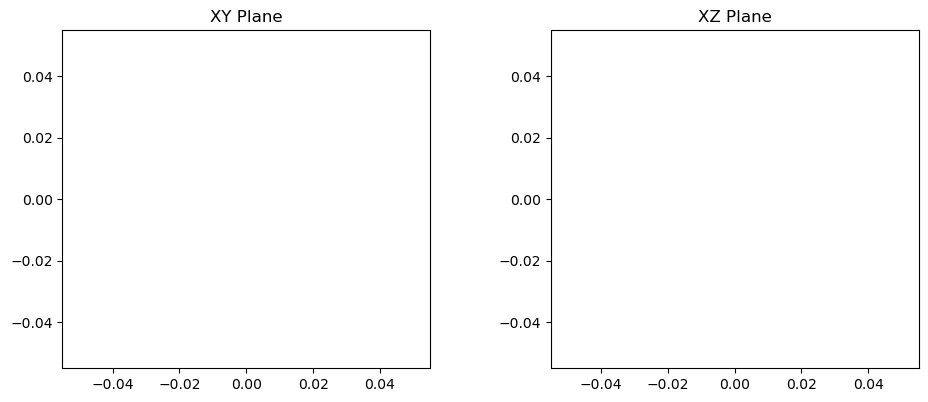

In [16]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data[data['variable_type']=='RRLyrae']['x'], data[data['variable_type']=='RRLyrae']['y'], color='red')
ax[0].scatter(data[data['variable_type']=='cepheid']['x'], data[data['variable_type']=='cepheid']['y'], color='blue')

ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data[data['variable_type']=='RRLyrae']['x'], data[data['variable_type']=='RRLyrae']['z'], color='red')
ax[1].scatter(data[data['variable_type']=='cepheid']['x'], data[data['variable_type']=='cepheid']['z'], color='blue')
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

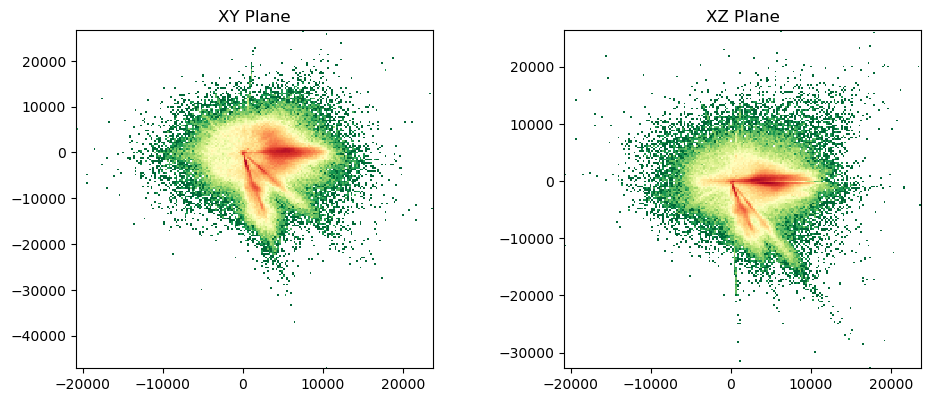

In [17]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [18]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['SOURCE_ID']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia DR3 Source ID')

#construct a label column
data['label'] = ['GaiaDR3_'+ str(source) for source in data['SOURCE_ID']]  #leaving for now in case we want to add other labels

In [19]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [20]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'variable_type', 'speck_label'])
columns

name    unit datatype width precision arraysize  \
0               x      pc  float64               6             
1               y      pc  float64               6             
2               z      pc  float64               6             
3           color  solLum  float32               2             
4             lum  solLum  float64               6             
5          absmag     mag  float64               6             
6          appmag     mag  float32               6             
7          texnum            int32                             
8         dist_ly     lyr  float64               1             
9           dcalc            int32                             
10              u  km / s  float64               6             
11              v  km / s  float64               6             
12              w  km / s  float64               6             
13          speed          float64               6             
14  variable_type            int32                             
15    speck_label              str                         *   

                     ucd                                        description  
0        pos.cartesian.x                      Position (x coordinate) in pc  
1        pos.cartesian.y                      Position (y coordinate) in pc  
2        pos.cartesian.z                      Position (z coordinate) in pc  
3             phys.color                                    Gaia BP-G color  
4        phys.luminosity                                 Stellar Luminosity  
5   phot.magAbs;em.opt.G                  Absolute magnitude in Gaia G-band  
6      phot.mag;em.opt.G                  Apparent magnitude in Gaia G-band  
7            meta.texnum                                     Texture Number  
8           pos.distance                            Distance from Sun (lyr)  
9             meta.dcalc  Distance Indicator: 1 indicates a Bailer-Jones...  
10       vel.cartesian.u      Heliocentric velocity towards Galactic Center  
11       vel.cartesian.v    Heliocentric velocity towards Galactic Rotation  
12       vel.cartesian.w  Heliocentric velocity towards Galactic North Pole  
13             vel.speed                        Total heliocentric velocity  
14        meta.vari_type  Type of Variable Star: 1 indicates Cepheid, 2 ...  
15               meta.id                                 Gaia DR3 Source ID

In [21]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

In [22]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [23]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))

In [24]:
data[data['SOURCE_ID']==4685634433183799680]

<Table length=0>
SOURCE_ID    ra     dec     pmra    pmdec   ...  color  speck_label label texnum
            deg     deg   mas / yr mas / yr ...  solLum                         
  int64   float64 float64 float64  float64  ... float32    str22    str27 int32 
--------- ------- ------- -------- -------- ... ------- ----------- ----- ------